# Classification Project

The goal is to build a classification model to predict if median housing prices in some districts are below or above a certain level (150000).

## Python setup

In [98]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import chi2_contingency, fisher_exact

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
%matplotlib inline

## Import data

In [99]:
# import data
URL = "https://raw.githubusercontent.com/jan-kirenz/project-Helenaschick/main/project_data.csv?token=GHSAT0AAAAAABQAIIJYYUUJFD55IYPG54ZCYPG7HTQ"
df = pd.read_csv(URL)

In [100]:
# show the first rows
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
0,-122.23,37.88,41.0years,880,129.0,322,126,8.3252,452600.0$,NEAR BAY,above
1,-122.22,37.86,21.0,7099,1106.0,2401,1138,8.3014,358500.0,NEAR BAY,above
2,-122.24,37.85,52.0,1467,190.0,496,177,7.2574,352100.0,NEAR BAY,above
3,-122.25,37.85,52.0,1274,235.0,558,219,5.6431,341300.0,NEAR BAY,above
4,-122.25,37.85,52.0,1627,280.0,565,259,3.8462,342200.0,NEAR BAY,above


In [101]:
# show the last rows
df.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
20635,-121.09,39.48,25.0,1665,374.0,845,330,1.5603,78100.0,INLAND,above
20636,-121.21,39.49,18.0,697,150.0,356,114,2.5568,77100.0,INLAND,above
20637,-121.22,39.43,17.0,2254,485.0,1007,433,1.7000,92300.0,INLAND,above
20638,-121.32,39.43,18.0,1860,409.0,741,349,1.8672,84700.0,INLAND,above
20639,-121.24,39.37,16.0,2785,616.0,1387,530,2.3886,89400.0,INLAND,above


In [102]:
# data overview (with meta data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  object 
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  object 
 9   ocean_proximity     20640 non-null  object 
 10  price_category      20640 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 1.7+ MB


## Tidy & transform data

In [103]:
# remove 'years' in line 0, column housing_median_age
df.housing_median_age[0] = '41.0'

C:\Users\chris\AppData\Local\Temp/ipykernel_12252/1385586849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.housing_median_age[0] = '41.0'


In [104]:
# remove '$' in line 0, column median_house_value
df.median_house_value[0] = '452600.0'

C:\Users\chris\AppData\Local\Temp/ipykernel_12252/3990115854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.median_house_value[0] = '452600.0'


In [105]:
# change data type
df['housing_median_age'] = pd.to_numeric(df['housing_median_age'])

In [106]:
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_household"] = df["total_bedrooms"] / df["households"]
df["size_household"] = df["population"] / df["households"]

In [107]:
# remove longitude and latitude (influence other variables), variables used for derivation of new columns
df_new = df.drop(columns=['longitude' , 'latitude', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_house_value'])
df.drop(columns=['longitude' , 'latitude', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_house_value'])

,housing_median_age,median_income,ocean_proximity,price_category,rooms_per_household,bedrooms_per_household,size_household
0,41.0,8.3252,NEAR BAY,above,6.984127,1.023810,2.555556
1,21.0,8.3014,NEAR BAY,above,6.238137,0.971880,2.109842
2,52.0,7.2574,NEAR BAY,above,8.288136,1.073446,2.802260
3,52.0,5.6431,NEAR BAY,above,5.817352,1.073059,2.547945
4,52.0,3.8462,NEAR BAY,above,6.281853,1.081081,2.181467
...,...,...,...,...,...,...,...
20635,25.0,1.5603,INLAND,above,5.045455,1.133333,2.560606
20636,18.0,2.5568,INLAND,above,6.114035,1.315789,3.122807
20637,17.0,1.7000,INLAND,above,5.205543,1.120092,2.325635
20638,18.0,1.8672,INLAND,above,5.329513,1.171920,2.123209


In [108]:
df_new.head()

,housing_median_age,median_income,ocean_proximity,price_category,rooms_per_household,bedrooms_per_household,size_household
0,41.0,8.3252,NEAR BAY,above,6.984127,1.023810,2.555556
1,21.0,8.3014,NEAR BAY,above,6.238137,0.971880,2.109842
2,52.0,7.2574,NEAR BAY,above,8.288136,1.073446,2.802260
3,52.0,5.6431,NEAR BAY,above,5.817352,1.073059,2.547945
4,52.0,3.8462,NEAR BAY,above,6.281853,1.081081,2.181467


In [109]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   housing_median_age      20640 non-null  float64
 1   median_income           20640 non-null  float64
 2   ocean_proximity         20640 non-null  object 
 3   price_category          20640 non-null  object 
 4   rooms_per_household     20640 non-null  float64
 5   bedrooms_per_household  20433 non-null  float64
 6   size_household          20640 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.1+ MB


housing_median_age          0
median_income               0
ocean_proximity             0
price_category              0
rooms_per_household         0
bedrooms_per_household    207
size_household              0
dtype: int64


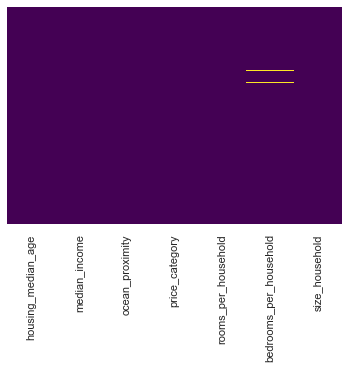

In [110]:
# show missing values (missing values - if present - will be displayed in yellow )
sns.heatmap(df_new.isnull(),yticklabels=False,cbar=False,cmap='viridis')
print(df_new.isnull().sum())

In [111]:
# remove rows with missing data
df_new_2 = df_new.dropna()
df_new.dropna()

,housing_median_age,median_income,ocean_proximity,price_category,rooms_per_household,bedrooms_per_household,size_household
0,41.0,8.3252,NEAR BAY,above,6.984127,1.023810,2.555556
1,21.0,8.3014,NEAR BAY,above,6.238137,0.971880,2.109842
2,52.0,7.2574,NEAR BAY,above,8.288136,1.073446,2.802260
3,52.0,5.6431,NEAR BAY,above,5.817352,1.073059,2.547945
4,52.0,3.8462,NEAR BAY,above,6.281853,1.081081,2.181467
...,...,...,...,...,...,...,...
20635,25.0,1.5603,INLAND,above,5.045455,1.133333,2.560606
20636,18.0,2.5568,INLAND,above,6.114035,1.315789,3.122807
20637,17.0,1.7000,INLAND,above,5.205543,1.120092,2.325635
20638,18.0,1.8672,INLAND,above,5.329513,1.171920,2.123209


In [112]:
df_new_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   housing_median_age      20433 non-null  float64
 1   median_income           20433 non-null  float64
 2   ocean_proximity         20433 non-null  object 
 3   price_category          20433 non-null  object 
 4   rooms_per_household     20433 non-null  float64
 5   bedrooms_per_household  20433 non-null  float64
 6   size_household          20433 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.2+ MB


## Data split

In [113]:
# encode our categorical features as one-hot numeric features (dummy variables)
dummies = pd.get_dummies(df_new_2[['ocean_proximity']])

dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ocean_proximity_<1H OCEAN   20433 non-null  uint8
 1   ocean_proximity_INLAND      20433 non-null  uint8
 2   ocean_proximity_ISLAND      20433 non-null  uint8
 3   ocean_proximity_NEAR BAY    20433 non-null  uint8
 4   ocean_proximity_NEAR OCEAN  20433 non-null  uint8
dtypes: uint8(5)
memory usage: 259.4 KB


In [114]:
# labels
y = df_new_2['price_category']

In [115]:
# drop the column with the outcome variable and categorical columns for which we already created dummy variables
X_numerical = df_new_2.drop(['price_category', 'ocean_proximity'], axis=1).astype('float64')

In [116]:
# create all features
X = pd.concat([X_numerical, dummies[['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   housing_median_age         20433 non-null  float64
 1   median_income              20433 non-null  float64
 2   rooms_per_household        20433 non-null  float64
 3   bedrooms_per_household     20433 non-null  float64
 4   size_household             20433 non-null  float64
 5   ocean_proximity_<1H OCEAN  20433 non-null  uint8  
 6   ocean_proximity_INLAND     20433 non-null  uint8  
 7   ocean_proximity_ISLAND     20433 non-null  uint8  
 8   ocean_proximity_NEAR BAY   20433 non-null  uint8  
dtypes: float64(5), uint8(4)
memory usage: 1.0 MB


In [117]:
# data split into train and test set with the first 70% of the data for training and the remaining 30% for testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [118]:
X_train.head()

,housing_median_age,median_income,rooms_per_household,bedrooms_per_household,size_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY
11909,32.0,2.3798,4.768067,1.036975,2.341176,0,1,0,0
11389,20.0,3.8187,5.099174,1.363636,2.181818,0,0,0,0
16935,34.0,3.4902,4.274064,1.082219,1.604278,0,0,0,0
9351,52.0,7.1155,8.822134,1.150198,2.889328,0,0,0,1
2087,52.0,1.0000,3.927083,1.010417,5.520833,0,1,0,0


In [119]:
# create new training dataset for data exploration
train_dataset = X_train.sample(frac=0.8, random_state=0)
train_dataset['price_category'] = y_train
test_dataset = df_new_2.drop(train_dataset.index)

train_dataset

,housing_median_age,median_income,rooms_per_household,bedrooms_per_household,size_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,price_category
18763,18.0,2.4036,4.912969,0.986348,2.387372,0,1,0,0,below
8088,34.0,2.8438,4.620968,1.069892,3.881720,0,0,0,0,below
15235,36.0,10.1768,6.102837,0.936170,2.517730,0,0,0,0,above
11613,21.0,4.8000,4.603774,1.056604,2.547170,1,0,0,0,above
1871,24.0,2.5875,9.775785,2.318386,3.385650,0,1,0,0,above
...,...,...,...,...,...,...,...,...,...,...
2300,28.0,3.5670,6.074468,1.070922,2.351064,0,1,0,0,above
9763,28.0,4.2500,5.653295,0.982808,2.779370,1,0,0,0,above
7514,22.0,2.0096,4.027027,1.045045,3.396396,1,0,0,0,below
20165,26.0,2.6893,5.355263,1.005639,2.599624,1,0,0,0,above


## Exploratory Data Analysis

In [120]:
train_dataset.groupby(by=['price_category']).describe()

housing_median_age                                         \
                            count       mean        std  min   25%   50%   
price_category                                                             
above                      9228.0  29.120286  12.388129  1.0  19.0  29.0   
below                      2214.0  26.783650  13.035760  2.0  16.0  26.0   

                           median_income            ...  \
                 75%   max         count      mean  ...   
price_category                                      ...   
above           37.0  52.0        9228.0  4.080489  ...   
below           37.0  52.0        2214.0  3.009371  ...   

               ocean_proximity_ISLAND      ocean_proximity_NEAR BAY            \
                                  75%  max                    count      mean   
price_category                                                                  
above                             0.0  1.0                   9228.0  0.116060   
below                             0.0  0.0                   2214.0  0.077236   

                                                   
                     std  min  25%  50%  75%  max  
price_category                                     
above           0.320314  0.0  0.0  0.0  0.0  1.0  
below           0.267025  0.0  0.0  0.0  0.0  1.0  

[2 rows x 72 columns]

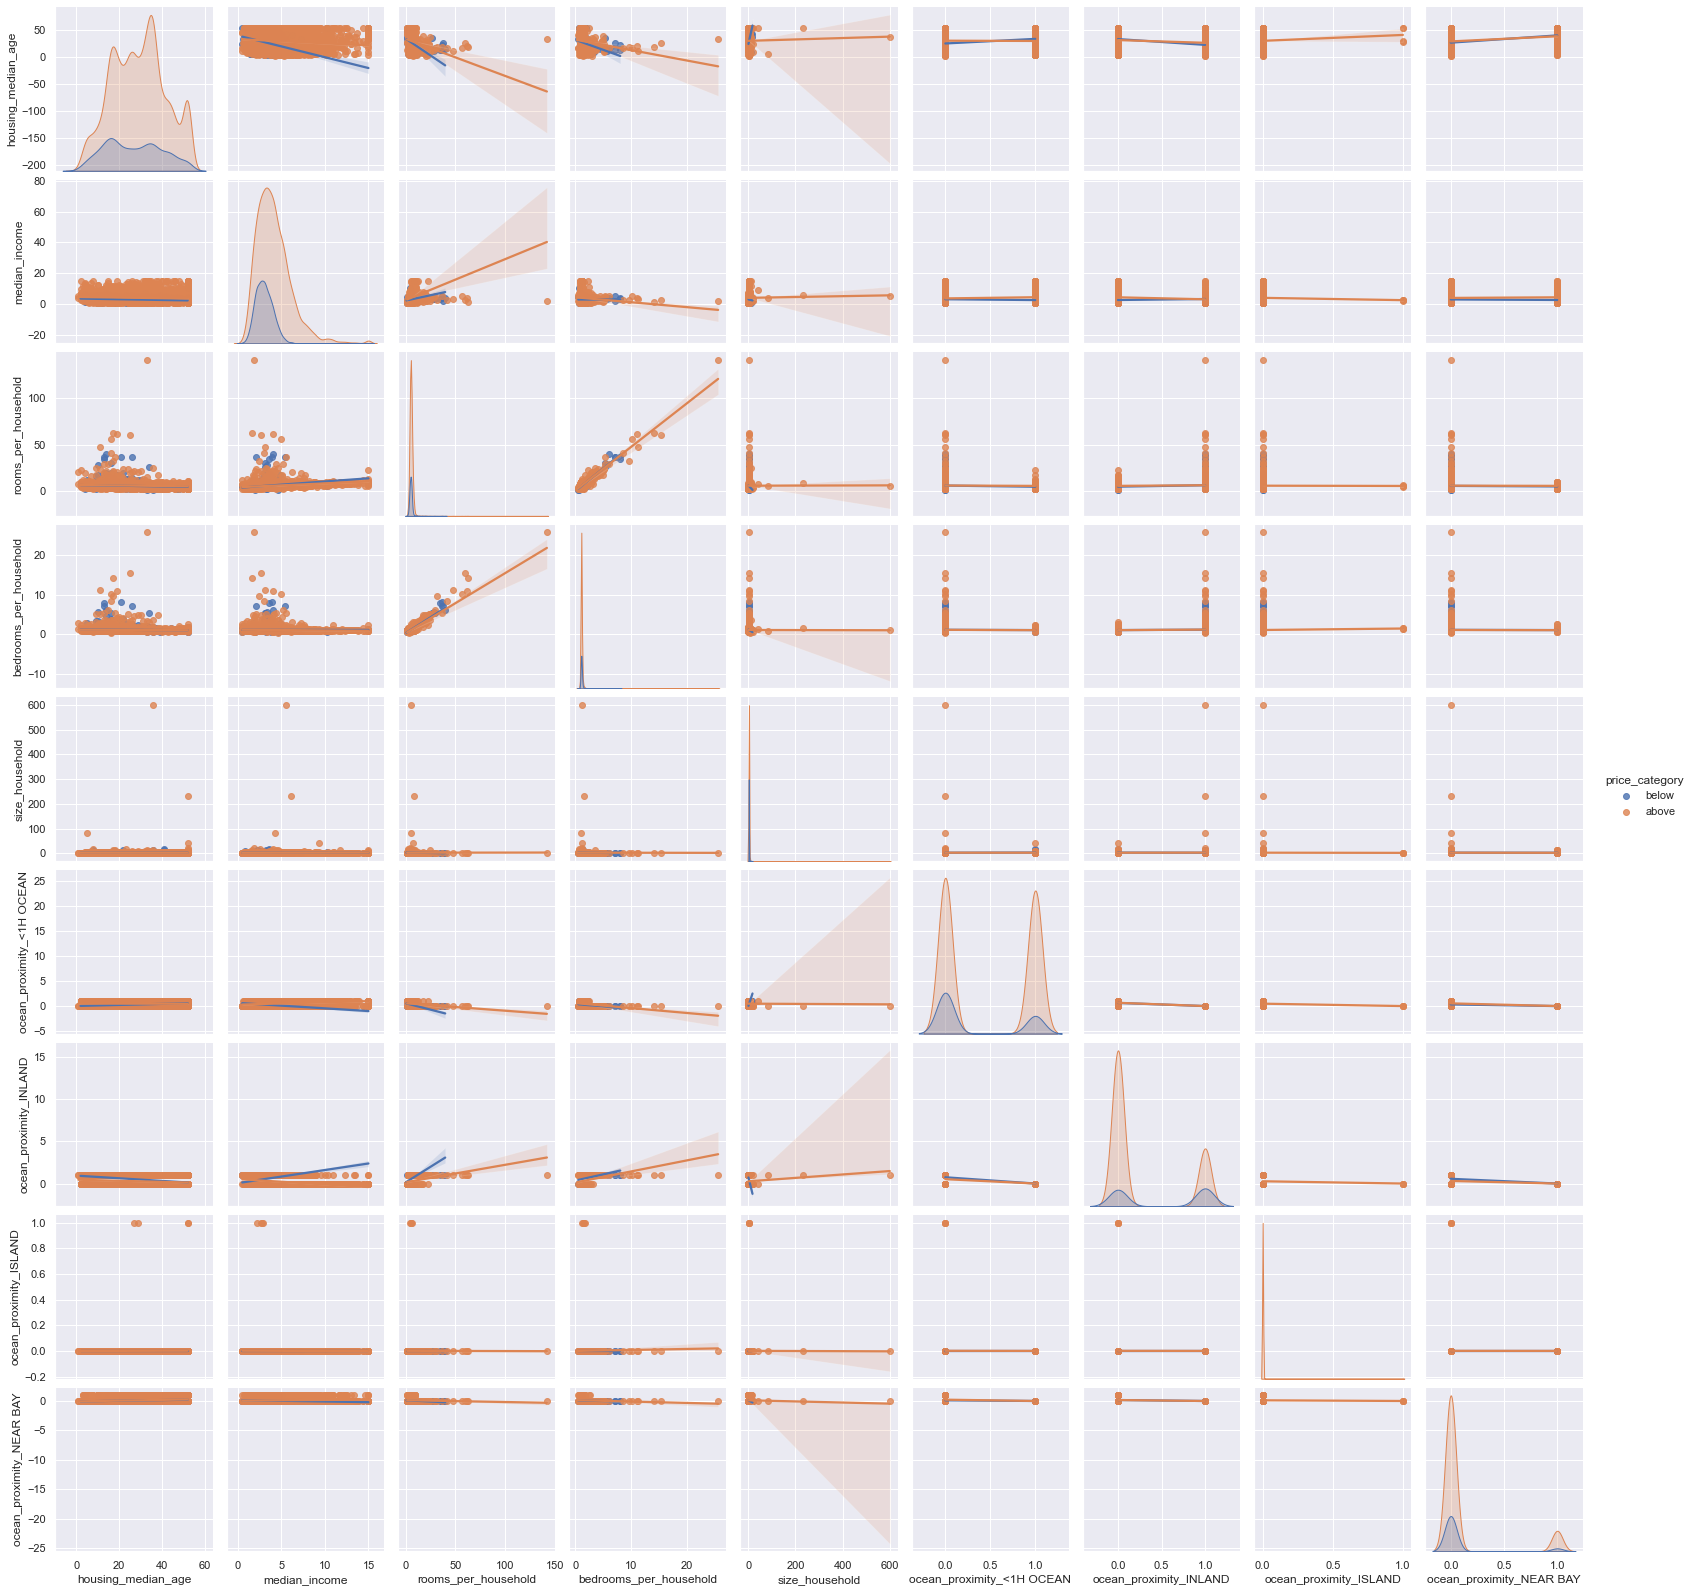

In [121]:
import seaborn as sns

sns.pairplot(hue='price_category', kind="reg", diag_kind="kde", data=train_dataset)

In [122]:
# Create correlation matrix for numerical variables
corr_matrix = train_dataset.corr()
corr_matrix

,housing_median_age,median_income,rooms_per_household,bedrooms_per_household,size_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY
housing_median_age,1.000000,-0.119843,-0.150029,-0.079951,0.011038,0.049952,-0.240197,0.016887,0.253513
median_income,-0.119843,1.000000,0.328729,-0.067715,0.006066,0.170079,-0.241848,-0.012701,0.057163
rooms_per_household,-0.150029,0.328729,1.000000,0.848694,-0.002729,-0.097707,0.146519,-0.001565,-0.029110
bedrooms_per_household,-0.079951,-0.067715,0.848694,1.000000,-0.004227,-0.090216,0.131967,0.015256,-0.034434
size_household,0.011038,0.006066,-0.002729,-0.004227,1.000000,0.005995,0.019959,-0.002064,-0.021494
ocean_proximity_<1H OCEAN,0.049952,0.170079,-0.097707,-0.090216,0.005995,1.000000,-0.611851,-0.016731,-0.312201
ocean_proximity_INLAND,-0.240197,-0.241848,0.146519,0.131967,0.019959,-0.611851,1.000000,-0.012789,-0.238634
ocean_proximity_ISLAND,0.016887,-0.012701,-0.001565,0.015256,-0.002064,-0.016731,-0.012789,1.000000,-0.006526
ocean_proximity_NEAR BAY,0.253513,0.057163,-0.029110,-0.034434,-0.021494,-0.312201,-0.238634,-0.006526,1.000000


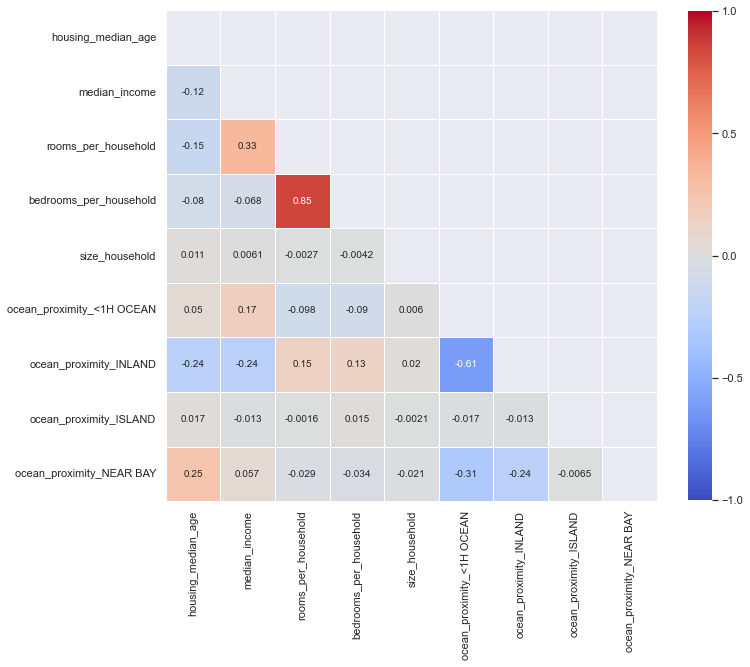

In [123]:
# Make a pretty heatmap

# Use a mask to plot only part of a matrix
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]= True

# Change size
plt.subplots(figsize=(11, 15))

# Build heatmap with additional options
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask, 
                      square = True, 
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .6,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 10})

**Findings:** rooms_per_household and bedrooms_per_household as well as ocean_proximity_<1H OCEAN and ocean_proximity_INLAND are highly correlated. This means we should not include these variables as predictors in our model.

## Model

In [124]:
# only use meaningful predictors
features_model = ['housing_median_age', 'median_income', 'size_household', 'ocean_proximity_ISLAND']

X_train = X_train[features_model] 
X_test = X_test[features_model]

In [125]:
import sklearn.linear_model as skl_lm

# model
clf = skl_lm.LogisticRegressionCV(penalty='l2')
# prediction
y_pred = clf.fit(X_train, y_train).predict(X_test)

In [126]:
model = smf.glm(formula = 'price_category ~ housing_median_age + median_income + size_household + ocean_proximity_ISLAND', data=train_dataset, family=sm.families.Binomial()).fit()


In [127]:
print(model.summary())

                                 Generalized Linear Model Regression Results                                  
Dep. Variable:     ['price_category[above]', 'price_category[below]']   No. Observations:                11442
Model:                                                            GLM   Df Residuals:                    11437
Model Family:                                                Binomial   Df Model:                            4
Link Function:                                                  logit   Scale:                          1.0000
Method:                                                          IRLS   Log-Likelihood:                -5174.4
Date:                                                Mon, 17 Jan 2022   Deviance:                       10349.
Time:                                                        21:11:28   Pearson chi2:                 1.25e+04
No. Iterations:                                                    20                                         
C

Model will predict label 'below'.

In [128]:
# update model by dropping all redictors with p>0.05

model_2 = smf.glm(formula = 'price_category ~ housing_median_age + median_income', data=train_dataset, family=sm.families.Binomial()).fit()
print(model_2.summary())

                                 Generalized Linear Model Regression Results                                  
Dep. Variable:     ['price_category[above]', 'price_category[below]']   No. Observations:                11442
Model:                                                            GLM   Df Residuals:                    11439
Model Family:                                                Binomial   Df Model:                            2
Link Function:                                                  logit   Scale:                          1.0000
Method:                                                          IRLS   Log-Likelihood:                -5176.2
Date:                                                Mon, 17 Jan 2022   Deviance:                       10352.
Time:                                                        21:11:28   Pearson chi2:                 1.25e+04
No. Iterations:                                                     6                                         
C

In [129]:
# Predict and join probabilty to original dataframe
train_dataset['y_score'] = model_2.predict()

In [130]:
# Use thresholds to discretize Probability
train_dataset['Threshold_0.4'] = np.where(train_dataset['y_score'] > 0.4, 'below', 'above')
train_dataset['Threshold_0.5'] = np.where(train_dataset['y_score'] > 0.5, 'below', 'above')
train_dataset['Threshold_0.6'] = np.where(train_dataset['y_score'] > 0.6, 'below', 'above')
train_dataset['Threshold_0.7'] = np.where(train_dataset['y_score'] > 0.7, 'below', 'above')

## Confusion Matrix

In [131]:
# Return the mean accuracy on the given test data and labels:
clf.score(X_test, y_test)

0.8086460032626427

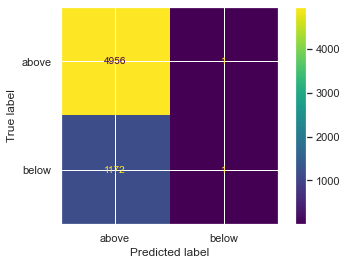

In [132]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [133]:
confusion_matrix(y_test, y_pred, labels=["above", "below"])

array([[4956,    1],
       [1172,    1]], dtype=int64)

In [134]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['above', 'below']))

              precision    recall  f1-score   support

       above       0.81      1.00      0.89      4957
       below       0.50      0.00      0.00      1173

    accuracy                           0.81      6130
   macro avg       0.65      0.50      0.45      6130
weighted avg       0.75      0.81      0.72      6130



**Findings:**
* **Precision** describes what proportion of positive identifications was actually correct (optimum: 1) --> 0.65 is okay
* **Recall** describes what proportion og actual positives was identified correctly (optimum: 1) --> 0.5 is not good
* **F1-Score** seeks balabce between precision and recall in case of uneven class distribution (optimum: 1) --> 0.45 is not good

In [135]:
pred_proba = clf.predict_proba(X_test)

## Use different thresholds

In [140]:
list = ['Threshold_0.4', 'Threshold_0.5']
target_names = ['below', 'above']

for i in list:
     print("Threshold:", i)
     print(classification_report(train_dataset['price_category'], train_dataset[i], target_names=target_names))

Threshold: Threshold_0.4
              precision    recall  f1-score   support

       below       1.00      0.00      0.00      9228
       above       0.19      1.00      0.32      2214

    accuracy                           0.19     11442
   macro avg       0.60      0.50      0.16     11442
weighted avg       0.84      0.19      0.06     11442

Threshold: Threshold_0.5
              precision    recall  f1-score   support

       below       0.64      0.00      0.01      9228
       above       0.19      0.99      0.32      2214

    accuracy                           0.19     11442
   macro avg       0.42      0.50      0.17     11442
weighted avg       0.55      0.19      0.07     11442



In [141]:
list = ['Threshold_0.6', 'Threshold_0.7']
target_names = ['below', 'above']

for i in list:
     print("Threshold:", i)
     print(classification_report(train_dataset['price_category'], train_dataset[i], target_names=target_names))

Threshold: Threshold_0.6
              precision    recall  f1-score   support

       below       0.77      0.04      0.07      9228
       above       0.19      0.95      0.32      2214

    accuracy                           0.21     11442
   macro avg       0.48      0.49      0.20     11442
weighted avg       0.66      0.21      0.12     11442

Threshold: Threshold_0.7
              precision    recall  f1-score   support

       below       0.72      0.15      0.25      9228
       above       0.18      0.75      0.28      2214

    accuracy                           0.27     11442
   macro avg       0.45      0.45      0.27     11442
weighted avg       0.61      0.27      0.26     11442



**Findings:**
* **Precision** describes what proportion of positive identifications was actually correct (optimum: 1) --> Threshold_0.4 is best
* **Recall** describes what proportion og actual positives was identified correctly (optimum: 1) --> Threshold_0.4 and Threshold_0.5 are best
* **F1-Score** seeks balabce between precision and recall in case of uneven class distribution (optimum: 1) --> Threshold_0.7 is best
* When we have a case where it is important to predict true positives correctly and there is a cost associated with false positives (customer might get mad for high price prediction), then we should use precision --> Threshold_0.4
* If we want a balance between recall and precision, we should use the F1-Score --> Threshold_0.7 (and it does not contain 0)

## Use test data

In [143]:
# Predict test data
y_score_test = model_2.predict(X_test)

thresh_04_test = np.where(y_score_test > 0.4, 'below', 'above')

print(classification_report(y_test, thresh_04_test, target_names=target_names))

              precision    recall  f1-score   support

       below       1.00      0.00      0.00      4957
       above       0.19      1.00      0.32      1173

    accuracy                           0.19      6130
   macro avg       0.60      0.50      0.16      6130
weighted avg       0.85      0.19      0.06      6130

